## Keras Word Embedding and LSTM. Sentence as sequence

https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470
https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [239]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from keras.layers import Bidirectional, Dense, Dropout, LSTM
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from os.path import join

In [54]:
FEATURES_DIR = join("..", "feature_extraction", "feature_outputs")
DATA_FILES_DIR = join("..", "feature_extraction", "data_files")
chat_logs_filename = join(DATA_FILES_DIR, "gnue_irc_chat_logs_preprocessed.txt")
summarized_chat_date_partitions_filename = join(
    DATA_FILES_DIR, "summarized_chat_date_partitions_cumulative_count.csv"
)
summarized_chat_log_ids_filename = join(DATA_FILES_DIR, "summarized_chat_log_ids.csv")

In [40]:
summarized_chat_date_partitions = pd.read_csv(summarized_chat_date_partitions_filename)

In [42]:
summarized_chat_date_partitions.tail(8)

,min_log_id,date_of_log,chat_line_count,cumulative_count
19,473197,2001-11-07,1990,16079
20,495175,2001-11-13,1051,17130
21,497259,2001-11-14,536,17666
22,526307,2001-11-15,1053,18719
23,531627,2001-11-12,1348,20067
24,579591,2001-10-24,162,20229
25,586206,2001-10-23,165,20394
26,623684,2001-10-25,321,20715


In [43]:
index_for_validation_test_split = summarized_chat_date_partitions.tail(4)["cumulative_count"]
index_for_validation_test_split = index_for_validation_test_split.values[0]
index_for_train_validation_split = summarized_chat_date_partitions.tail(8)["cumulative_count"]
index_for_train_validation_split = index_for_train_validation_split.values[0]
print(index_for_train_validation_split)
print(index_for_validation_test_split)

16079
20067


In [62]:
summarized_chat_log_ids = pd.read_csv(
    summarized_chat_log_ids_filename,
    names=["log_id", "is_summary"]
)

In [63]:
summarized_chat_log_ids.head()

,log_id,is_summary
0,85350,0
1,85351,0
2,85352,0
3,85353,0
4,85354,0


In [69]:
def get_summarized_chat_logs(chat_logs_filename, summarized_chat_log_ids):
    summarized_chat_log_ids = set(summarized_chat_log_ids)
    chats = []
    with open(chat_logs_filename) as chat_logs:
        line_number = 1
        for chat_log in chat_logs:
            if line_number in summarized_chat_log_ids:
                chats.append(chat_log)
            line_number += 1
    return chats

In [70]:
chat_logs = get_summarized_chat_logs(chat_logs_filename, summarized_chat_log_ids.log_id.values)
chat_logs[:5]

['great\n',
 'i dont recall you ever telling me what you do at your job\n',
 "and you probably can't be persuaded to tell me now.\n",
 'due to your persistant funkitude\n',
 'umm, he sits around on irc all day ;)\n']

In [71]:
# Create a Tokenizer Object
tokenizer = Tokenizer(
    num_words=None,
    filters="\n",
    lower = False, 
    split = ' '
)
tokenizer.fit_on_texts(chat_logs)

In [72]:
sequences = tokenizer.texts_to_sequences(chat_logs)

In [73]:
sequences[4]

[3099, 72, 4137, 300, 16, 584, 34, 309, 54]

In [184]:
word_indexes = tokenizer.index_word
def get_words_at_line_number(word_indexes, line_number):
    return " ".join(word_indexes[word] for word in sequences[line_number])

In [186]:
get_words_at_line_number(word_indexes, 2)

"and you probably can't be persuaded to tell me now."

In [75]:
tokenizer.index_word[356]

'language'

In [221]:
train_X = np.array(sequences[:index_for_train_validation_split])
validation_X = np.array(sequences[index_for_train_validation_split:index_for_validation_test_split])
test_X = np.array(sequences[index_for_validation_test_split:])
print(train_X.shape)
print(test_X.shape)
print(train_X[:1])
print(len(test_X))
test_X[-5:]

(16079,)
(648,)
20085
[list([547])]
648


array([list([107, 18365]), list([128, 9, 31, 1456]),
       list([18366, 342, 36, 3591, 515, 29, 18367, 14]), list([14]),
       list([1454])], dtype=object)

In [147]:
# create a one hot encoding for the target column
chat_log_labels = to_categorical(summarized_chat_log_ids.is_summary)
# train_y_nums = train_df.is_summary.values
# validation_y = to_categorical(validation_df.is_summary)
# validation_y_nums = validation_df.is_summary.values
# test_y = to_categorical(test_df.is_summary)
# test_y_nums = test_df.is_summary.values

# chat_log_labels = np.array(summarized_chat_log_ids.is_summary)
train_y = chat_log_labels[:index_for_train_validation_split]
validation_y = chat_log_labels[index_for_train_validation_split:index_for_validation_test_split]
test_y = chat_log_labels[index_for_validation_test_split:]

In [148]:
test_y[80:100]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [234]:
# pad input sequences
max_chat_length = max(len(seq) for seq in sequences)
train_X = sequence.pad_sequences(train_X, maxlen=max_chat_length)
validation_X = sequence.pad_sequences(validation_X, maxlen=max_chat_length)
test_X = sequence.pad_sequences(test_X, maxlen=max_chat_length)

In [235]:
print(train_X.shape)
print(test_X.shape)
print(validation_X.shape)
print(validation_X[0])

(16079, 73)
(648, 73)
(3988, 73)
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     4  1575    20   103    15     3 15875   908    12   125  1051
    14]


In [240]:
# create the model
top_words = 100000
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_chat_length))
model.add(Bidirectional(LSTM(100), input_shape=(max_chat_length, 1)))
model.add(Dense(2, activation='sigmoid'))

In [241]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 73, 32)            3200000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               106400    
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 402       
Total params: 3,306,802
Trainable params: 3,306,802
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start = time.time()
history = model.fit(
    train_X, 
    train_y, 
    validation_data=(validation_X, validation_y), 
    epochs=100, 
    batch_size=64
)
end = time.time()
print(end-start)

Train on 16079 samples, validate on 3988 samples
Epoch 1/100
16079/16079 [==============================] - 30s 2ms/step - loss: 0.0165 - acc: 0.9940 - val_loss: 0.2794 - val_acc: 0.9431
Epoch 2/100
16079/16079 [==============================] - 32s 2ms/step - loss: 0.0153 - acc: 0.9947 - val_loss: 0.3203 - val_acc: 0.9361
Epoch 3/100
  640/16079 [>.............................] - ETA: 30s - loss: 0.0092 - acc: 0.9984

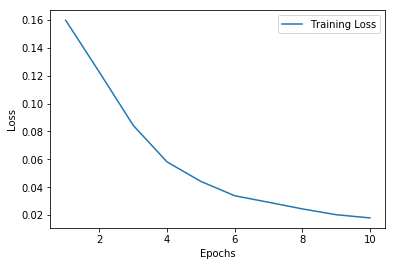

In [243]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [244]:
test_y_predictions = model.predict(test_X)
validation_y_predictions = model.predict(validation_X)

test_y_argmax = np.argmax(test_y,axis=1)
validation_y_argmax = np.argmax(validation_y,axis=1)

test_y_predictions_argmax = np.argmax(test_y_predictions, axis=1)
validation_y_predictions_argmax = np.argmax(validation_y_predictions, axis=1)

In [245]:
test_y_predictions[:10]

array([[9.3932223e-01, 5.1349401e-05],
       [9.4361091e-01, 5.9992075e-05],
       [9.7584641e-01, 1.4901161e-05],
       [9.8614192e-01, 6.4969063e-06],
       [9.8476815e-01, 7.1525574e-06],
       [9.8419207e-01, 7.8976154e-06],
       [2.6250041e-01, 5.6813359e-03],
       [6.1580455e-01, 1.2086034e-03],
       [6.5217966e-01, 1.3580620e-03],
       [6.6993403e-01, 7.0789456e-04]], dtype=float32)

In [246]:
test_y_predictions_argmax[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [247]:
test_y_argmax[:100]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [248]:
print(classification_report(test_y_argmax, test_y_predictions_argmax))
print(confusion_matrix(test_y_argmax, test_y_predictions_argmax))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       619
           1       0.08      0.07      0.07        29

   micro avg       0.92      0.92      0.92       648
   macro avg       0.52      0.52      0.52       648
weighted avg       0.92      0.92      0.92       648

[[595  24]
 [ 27   2]]


In [249]:
print(classification_report(validation_y_argmax, validation_y_predictions_argmax))
print(confusion_matrix(validation_y_argmax, validation_y_predictions_argmax))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      3872
           1       0.04      0.06      0.05       116

   micro avg       0.93      0.93      0.93      3988
   macro avg       0.51      0.51      0.51      3988
weighted avg       0.94      0.93      0.94      3988

[[3710  162]
 [ 109    7]]


In [208]:
y_actual_and_prediction = list(zip(test_y_argmax, test_y_predictions_argmax))
[y for i, y in enumerate(y_actual_and_prediction)][80:100]

[(0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 1),
 (1, 0),
 (1, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 0),
 (0, 1)]

In [225]:
log_ids_for_false_positives = []
log_ids_for_false_negatives = []
log_ids_for_true_positives = []
offset = index_for_validation_test_split
for index, value in enumerate(y_actual_and_prediction):
    if value == (0, 1):
        log_ids_for_false_positives.append(offset + index)
    elif value == (1, 0):
        log_ids_for_false_negatives.append(offset + index)
    elif value == (1,1):
        log_ids_for_true_positives.append(offset + index)
    
log_ids_for_false_positives = [index_for_validation_test_split + index for index, value in enumerate(y_actual_and_prediction) if value==(0, 1)]
log_ids_for_false_positives = [index_for_validation_test_split + index for index, value in enumerate(y_actual_and_prediction) if value==(0, 1)]
print(len(log_ids_for_false_positives))
print(len(log_ids_for_false_negatives))
print(len(log_ids_for_true_positives))
log_ids_for_false_positives[:10]

32
25
4


[20085, 20105, 20106, 20109, 20136, 20138, 20166, 20202, 20211, 20248]

In [224]:
for log_id in log_ids_for_false_positives:
    print(get_words_at_line_number(word_indexes, log_id))

or, for simplicity, print md5.new(string).digest() :)
BUT from geas/DBdriver.py:
def _make_passkey(self, user, passwd, random):
def _hexstr(self, s):
but when I update or co, it comes back
doesn't jamest have access to the cvs server?
either that or I customize interchange
(basically Python-based web application services
webware and GNUe might be interesting
real or imagined
any suggestions/comments?
doesn't it still have a usenet gateway?
and windows isnt a 'monitorless' operating system
there is an option to open as access as 97
i will get 97 up here pretty quick
and be much more 'official' than informal help
more official?
i.e. accountable
any non ie 5.0 or greater browser in fact
F*** YOU! No MSN for you.
this is really really incredible
I always wondered if gnuebot and bigbrother secretly fought in the background
either with win2k or kde&linux
the major hangup is of course.....drumroll....Office
what's it running per seat?
I strongly dislike cygwin's setup
if exists (select 1 from

In [226]:
for log_id in log_ids_for_true_positives:
    print(get_words_at_line_number(word_indexes, log_id))

pyro is an object system like what gcomm will be
the python email client
you should be able to access it via geas
and todo tool


In [227]:
for log_id in log_ids_for_false_negatives:
    print(get_words_at_line_number(word_indexes, log_id))

btw, why are ou guys calling this abstraction thingy GComm when Dave has a project called GNU Comm (GComm fr short)?
as far as I'm concerned, GComm is our internal package name... to the external world, it's GNUe Common
but that is a good point
by same guys that wrote pygmy
I need a production quality GNUe web shopping cart ;-)
anything is possible I know, but ideally we need to get ideas on some sort of php and GEAS interface
guess I'll just customize interchange.. hopefully actually have it done in a few days
our inventory package isn't completed
but if you have an inventory package
I know a web interface for GNUe Forms is in the works, but I'm sure you need something relatively quickly
madlocke was working on that, but as you probably know, he's been out of commission (sick) lately
a new release (feature wise) is probably about 3 or 4 weeks away since the db upgrade is going to be huge
I may make an interim bug fix/small feature release to get some of the email support down
but we a